## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-8
EPOCHS = 10
T = 10

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

flag_subsampled = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [3]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site B - 2020
(1943716, 28, 6) (1943716,)


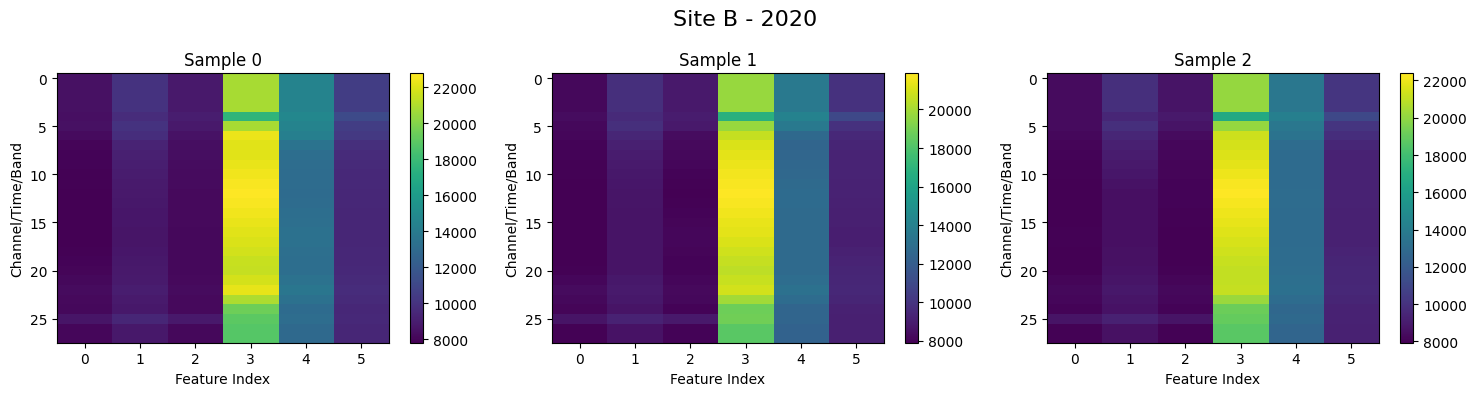

In [4]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = 9293.7332, Std = 1062.0828
Feature 1: Mean = 10402.3986, Std = 1328.2403
Feature 2: Mean = 10579.1004, Std = 1999.1082
Feature 3: Mean = 18968.7555, Std = 4274.7314
Feature 4: Mean = 16319.4431, Std = 3346.2848
Feature 5: Mean = 13205.7260, Std = 3494.6972

Global Mean: 13128.1928
Global Std Dev: 4500.1056


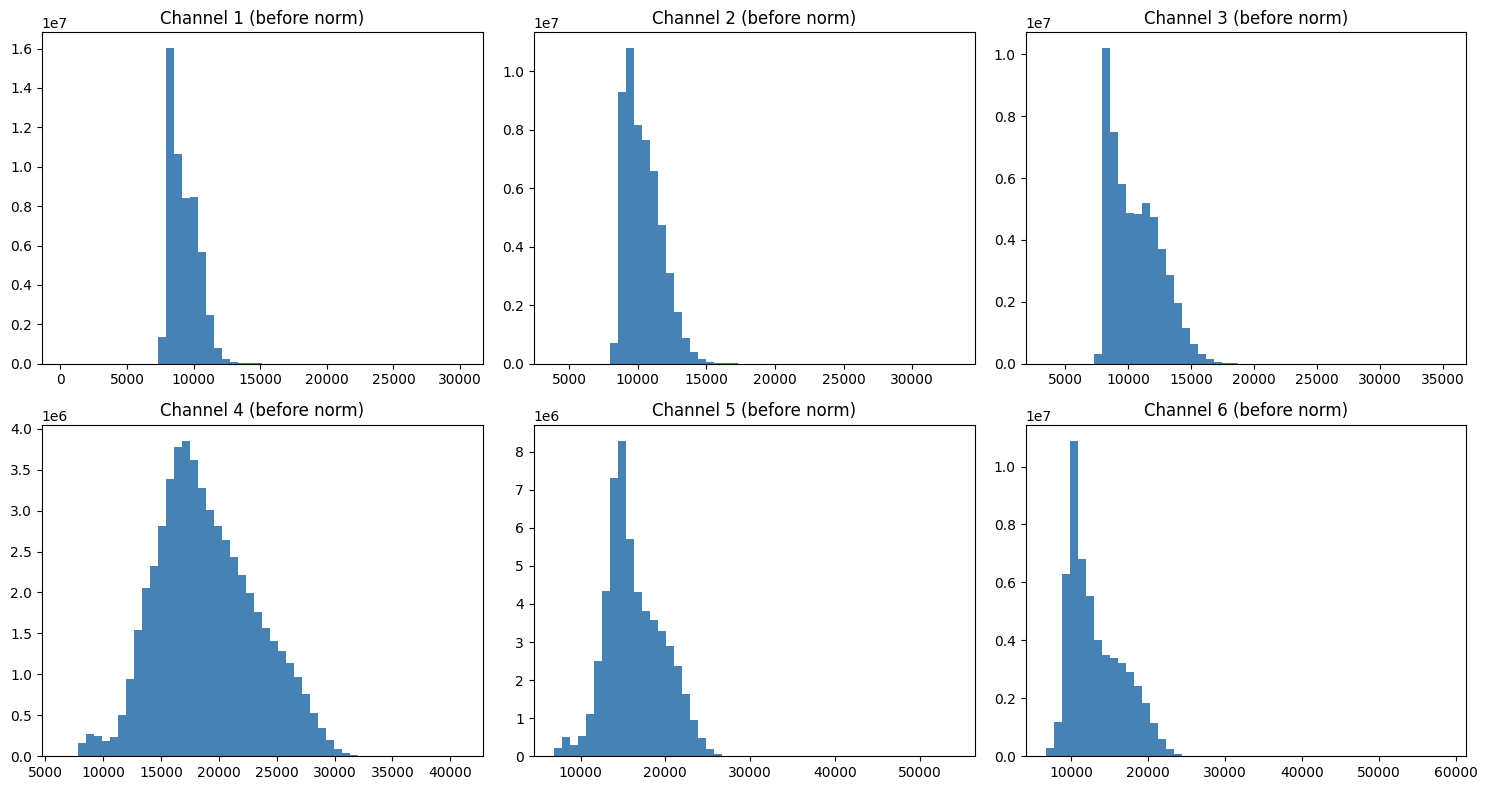

In [6]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# Before normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (before norm)')
plt.tight_layout()
plt.show()

## Preprocessing the Input

In [7]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

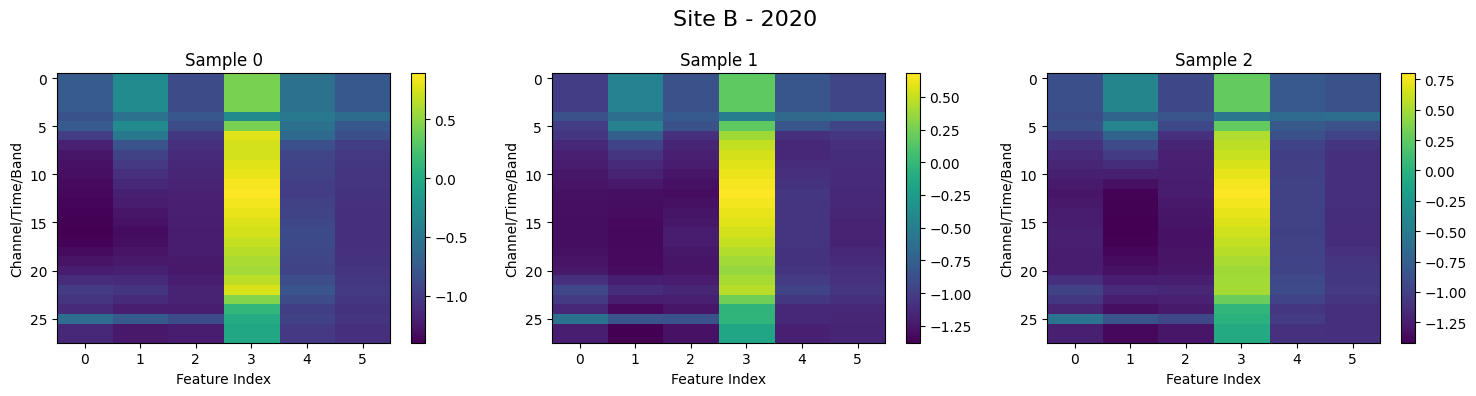

In [8]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = -0.0000, Std = 0.8846
Feature 1: Mean = -0.0000, Std = 0.8950
Feature 2: Mean = 0.0000, Std = 0.8862
Feature 3: Mean = 0.0001, Std = 0.9253
Feature 4: Mean = 0.0000, Std = 0.9230
Feature 5: Mean = 0.0000, Std = 0.8994

Global Mean: -0.0000
Global Std Dev: 1.0000


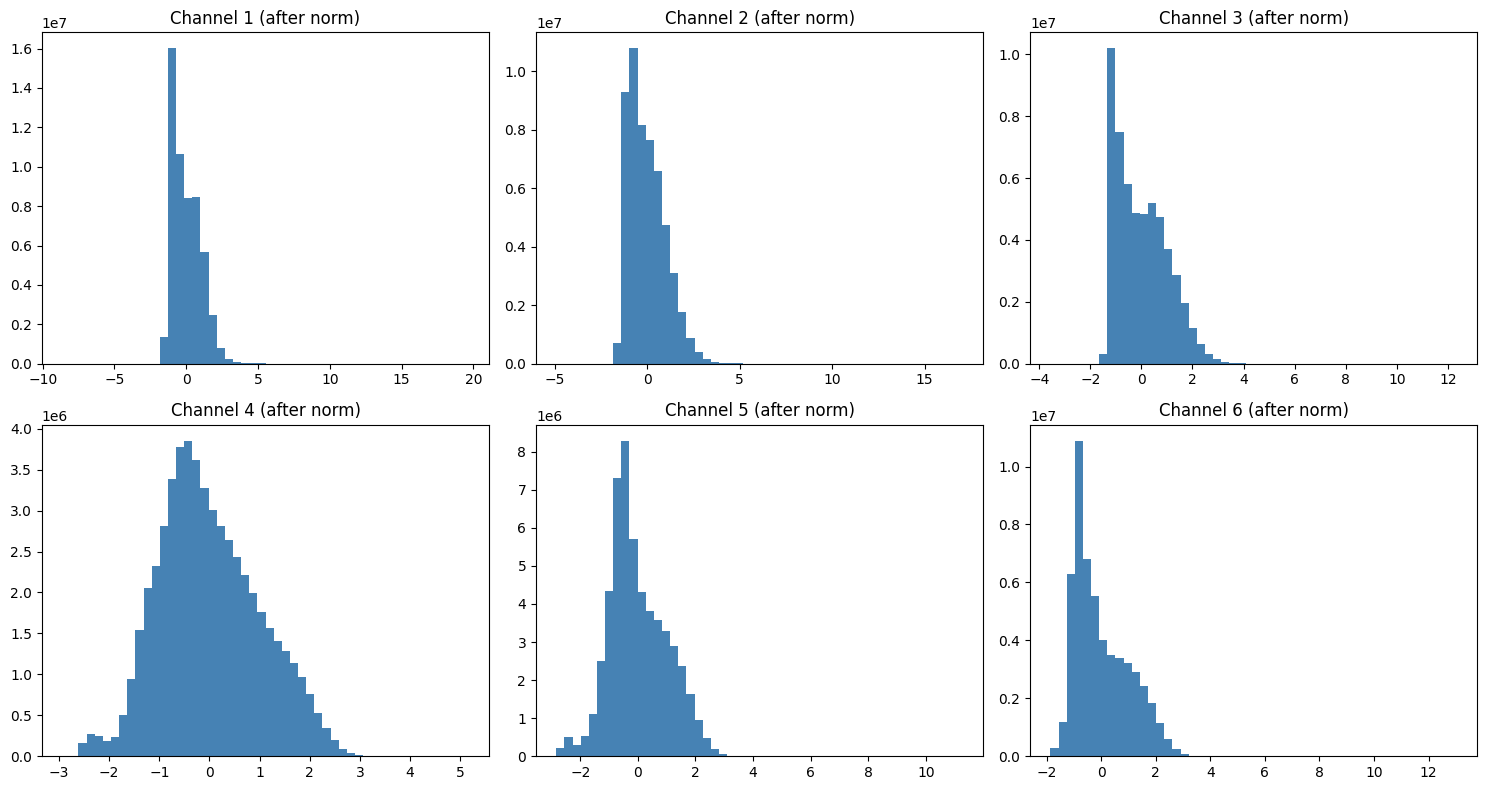

In [10]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# After normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (after norm)')
plt.tight_layout()
plt.show()

## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


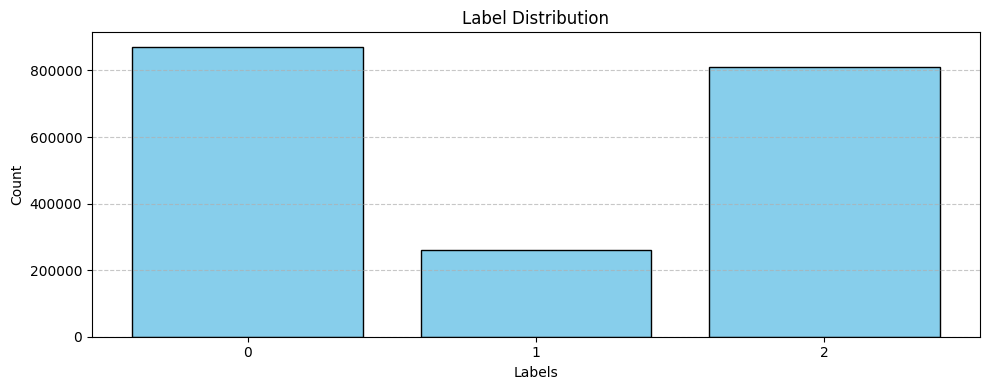

In [11]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Splits

In [12]:
# Taking only 25% percent of the data
X_subset, X_test, y_subset, y_test = train_test_split(X, y, test_size=0.75, stratify=y, random_state=42)
print('Subset Data:', X_subset.shape, y_subset.shape)
print('Test Data:', X_test.shape, y_test.shape)

Subset Data: (485929, 28, 6) (485929,)
Test Data: (1457787, 28, 6) (1457787,)


In [13]:
# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(388743, 28, 6) (388743,)
(97186, 28, 6) (97186,)


In [14]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0013, Std = 0.9957
Feature 1: Mean = 0.0013, Std = 0.9936
Feature 2: Mean = 0.0009, Std = 0.9921
Feature 3: Mean = 0.0006, Std = 0.9914
Feature 4: Mean = 0.0005, Std = 0.9904
Feature 5: Mean = 0.0004, Std = 0.9946

Global Mean: 0.0008
Global Std Dev: 1.0006




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         174206    44.81%
1         52155     13.42%
2         162382    41.77%

Total samples: 388743


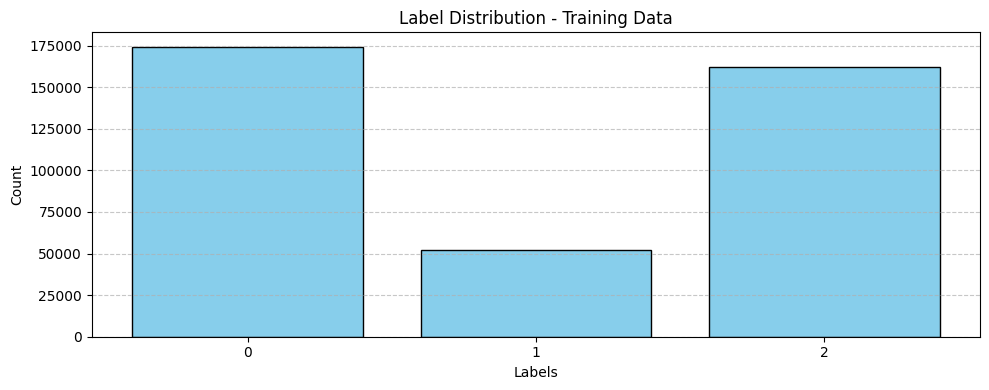

In [15]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [16]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
train_dataset = Conv1dDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = Conv1dDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = Conv1dDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [18]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)

In [19]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

In [20]:
########################################
# Model Initialization
########################################
if not flag_subsampled:
    model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
    model = torch.compile(model, backend='eager')
    print(model)
    
    # Loading model trained on SiteA-2019
    checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint)

## Evaluation Function

In [21]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [22]:
def evaluate(model, dataloader, T, device):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, _ = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, kappa, per_class_f1, avg_f1, cm

In [23]:
# acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)

# # Printing and plotting
# print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
# print(f"Cohen's Kappa: {kappa:.4f}")
# print(f"Per-class F1: {per_class_f1}")
# print(f"Average F1 (macro): {avg_f1:.4f}")

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues")
# plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
# plt.tight_layout()
# plt.show()

## Training Loop

In [24]:
# ===== Class weights =====
all_labels = []
for _, y_batch in train_dataloader:
    all_labels.append(y_batch.numpy())

all_labels = np.concatenate(all_labels)
classes = np.unique(all_labels)
class_weights_np = compute_class_weight(class_weight='balanced',
                                        classes=classes, y=all_labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
class_weights = torch.clamp(class_weights, max=1.25) # Clipping to max 1.00
print("Class weights:", class_weights)

Class weights: tensor([0.7438, 1.2500, 0.7980], device='cuda:0')


In [25]:
# ===== Optimizer =====
if not flag_subsampled:
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [26]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [27]:
# ===== Training Loop =====
def train(model, train_dataset, train_loader, val_loader, optimizer, KL_WEIGHT=1e-8, EPOCHS=15, T=15):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(EPOCHS):
        # === TRAIN ===
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        for x_batch, y_batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
    
            optimizer.zero_grad()
    
            # Forward pass with T stochastic samples
            outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL
    
            # Mean NLL across T samples
            nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            
            # ELBO Loss
            loss = nll_mean + KL_WEIGHT * kl
    
            # Backprop
            loss.backward()
            optimizer.step()
    
            # Stats
            train_loss += loss.item() * x_batch.size(0)
            train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')
    
        # === VALIDATION ===
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
    
        with torch.no_grad():
            for x_batch, y_batch in tqdm(val_loader, desc='Validation'):
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
    
                outputs, kl = model(x_batch, sample=False, n_samples=1)  # deterministic eval
                nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
                loss = nll + KL_WEIGHT * kl
    
                val_loss += loss.item() * x_batch.size(0)
                val_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        val_loss /= len(val_dataset)
        val_acc /= len(val_dataset)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}") 

    return train_losses, val_losses, train_accs, val_accs

In [28]:
# Subsampled Training
def subsampled_training(X_train, y_train, val_dataloader, start, end, step):
    subset_sizes = list(range(start, end+1, step))
    print(subset_sizes)
    
    elbow_history = {
        "subset_size": [],
        "train_accuracy": [],
        "train_loss": [],
        "val_accuracy": [],
        "val_loss": [],
        "val_avg_f1": [],
        "kappa": []
    }
    
    for size in subset_sizes:
        print(f"\nTraining with {size} samples...")
        
        subset_indices = np.arange(size)
        X_subsample = X_train[subset_indices]
        y_subsample = y_train[subset_indices]
    
        # Create dataset & dataloader
        subsample_dataset = Conv1dDataset(X_subsample, y_subsample)
        subsample_loader = DataLoader(subsample_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
        # Fresh model for each subset and optimizer
        model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
        model = torch.compile(model, backend='eager')
        checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
        model.load_state_dict(checkpoint)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)  
    
        # Train
        train_losses, val_losses, train_accs, val_accs = train(model, subsample_dataset, subsample_loader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)
        # Evaluate
        acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
        # Printing and plotting
        print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
        print(f"Cohen's Kappa: {kappa:.4f}")
        print(f"Per-class F1: {per_class_f1}")
        print(f"Average F1 (macro): {avg_f1:.4f}")
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
        plt.tight_layout()
        plt.show()
        
        # Save final epoch stats
        elbow_history["subset_size"].append(size)
        elbow_history["train_loss"].append(train_losses[-1])
        elbow_history["train_accuracy"].append(train_accs[-1])
        elbow_history["val_accuracy"].append(val_accs[-1])
        elbow_history["val_loss"].append(val_losses[-1])
        elbow_history["val_avg_f1"].append(avg_f1)
        elbow_history["kappa"].append(kappa)

    return elbow_history

## Training

[25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 250000]

Training with 25000 samples...


Training Epoch 1: 100%|██████████| 391/391 [00:12<00:00, 31.43it/s]


Loss: 0.3685 + 1e-08 * 2842602.5


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 126.50it/s]


Epoch [1/10] Train Loss: 0.4016, Train Acc: 0.8579 | Val Loss: 0.3208, Val Acc: 0.8832


Training Epoch 2: 100%|██████████| 391/391 [00:08<00:00, 44.16it/s]


Loss: 0.1934 + 1e-08 * 2796653.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.18it/s]


Epoch [2/10] Train Loss: 0.2988, Train Acc: 0.8940 | Val Loss: 0.2903, Val Acc: 0.8967


Training Epoch 3: 100%|██████████| 391/391 [00:08<00:00, 44.22it/s]


Loss: 0.2135 + 1e-08 * 2749722.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.49it/s]


Epoch [3/10] Train Loss: 0.2794, Train Acc: 0.9025 | Val Loss: 0.2819, Val Acc: 0.9005


Training Epoch 4: 100%|██████████| 391/391 [00:08<00:00, 44.01it/s]


Loss: 0.2613 + 1e-08 * 2709233.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.91it/s]


Epoch [4/10] Train Loss: 0.2656, Train Acc: 0.9070 | Val Loss: 0.2797, Val Acc: 0.9016


Training Epoch 5: 100%|██████████| 391/391 [00:09<00:00, 43.14it/s]


Loss: 0.2749 + 1e-08 * 2677983.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.33it/s]


Epoch [5/10] Train Loss: 0.2547, Train Acc: 0.9101 | Val Loss: 0.2748, Val Acc: 0.9035


Training Epoch 6: 100%|██████████| 391/391 [00:09<00:00, 41.81it/s]


Loss: 0.4553 + 1e-08 * 2652613.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.66it/s]


Epoch [6/10] Train Loss: 0.2426, Train Acc: 0.9159 | Val Loss: 0.2899, Val Acc: 0.8957


Training Epoch 7: 100%|██████████| 391/391 [00:08<00:00, 43.86it/s]


Loss: 0.3559 + 1e-08 * 2632705.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.26it/s]


Epoch [7/10] Train Loss: 0.2355, Train Acc: 0.9187 | Val Loss: 0.2778, Val Acc: 0.9012


Training Epoch 8: 100%|██████████| 391/391 [00:08<00:00, 43.67it/s]


Loss: 0.1804 + 1e-08 * 2618140.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.11it/s]


Epoch [8/10] Train Loss: 0.2260, Train Acc: 0.9224 | Val Loss: 0.2779, Val Acc: 0.9017


Training Epoch 9: 100%|██████████| 391/391 [00:08<00:00, 43.51it/s]


Loss: 0.1419 + 1e-08 * 2609399.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.32it/s]


Epoch [9/10] Train Loss: 0.2163, Train Acc: 0.9256 | Val Loss: 0.2765, Val Acc: 0.9020


Training Epoch 10: 100%|██████████| 391/391 [00:09<00:00, 43.39it/s]


Loss: 0.3151 + 1e-08 * 2607834.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 138.50it/s]


Epoch [10/10] Train Loss: 0.2090, Train Acc: 0.9291 | Val Loss: 0.2866, Val Acc: 0.9010


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:41<00:00, 141.35it/s]


Stochastic Accuracy (mean over T): 0.9012
Cohen's Kappa: 0.8374
Per-class F1: [0.90163345 0.91134521 0.89748001]
Average F1 (macro): 0.9035


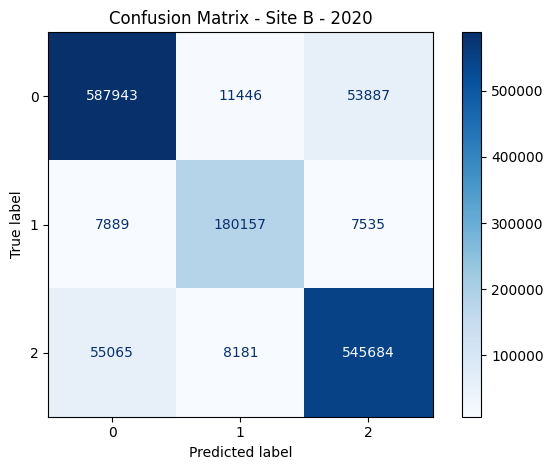


Training with 50000 samples...


Training Epoch 1: 100%|██████████| 782/782 [00:18<00:00, 42.50it/s]


Loss: 0.2835 + 1e-08 * 2799125.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.69it/s]


Epoch [1/10] Train Loss: 0.3580, Train Acc: 0.8729 | Val Loss: 0.2923, Val Acc: 0.8958


Training Epoch 2: 100%|██████████| 782/782 [00:18<00:00, 43.26it/s]


Loss: 0.0790 + 1e-08 * 2703031.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.30it/s]


Epoch [2/10] Train Loss: 0.2829, Train Acc: 0.8997 | Val Loss: 0.2820, Val Acc: 0.8998


Training Epoch 3: 100%|██████████| 782/782 [00:18<00:00, 43.31it/s]


Loss: 0.1155 + 1e-08 * 2620520.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.43it/s]


Epoch [3/10] Train Loss: 0.2658, Train Acc: 0.9067 | Val Loss: 0.2779, Val Acc: 0.9001


Training Epoch 4: 100%|██████████| 782/782 [00:18<00:00, 42.81it/s]


Loss: 0.2173 + 1e-08 * 2549556.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 138.70it/s]


Epoch [4/10] Train Loss: 0.2531, Train Acc: 0.9109 | Val Loss: 0.2625, Val Acc: 0.9065


Training Epoch 5: 100%|██████████| 782/782 [00:17<00:00, 43.86it/s]


Loss: 0.2511 + 1e-08 * 2496428.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.41it/s]


Epoch [5/10] Train Loss: 0.2440, Train Acc: 0.9131 | Val Loss: 0.2601, Val Acc: 0.9084


Training Epoch 6: 100%|██████████| 782/782 [00:17<00:00, 43.69it/s]


Loss: 0.5741 + 1e-08 * 2461243.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.38it/s]


Epoch [6/10] Train Loss: 0.2349, Train Acc: 0.9171 | Val Loss: 0.2597, Val Acc: 0.9076


Training Epoch 7: 100%|██████████| 782/782 [00:18<00:00, 42.40it/s]


Loss: 0.4837 + 1e-08 * 2431043.0


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 129.68it/s]


Epoch [7/10] Train Loss: 0.2291, Train Acc: 0.9186 | Val Loss: 0.2575, Val Acc: 0.9079


Training Epoch 8: 100%|██████████| 782/782 [00:18<00:00, 42.91it/s]


Loss: 0.2061 + 1e-08 * 2410873.25


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 136.14it/s]


Epoch [8/10] Train Loss: 0.2184, Train Acc: 0.9228 | Val Loss: 0.2687, Val Acc: 0.9067


Training Epoch 9: 100%|██████████| 782/782 [00:18<00:00, 42.95it/s]


Loss: 0.1673 + 1e-08 * 2399089.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.63it/s]


Epoch [9/10] Train Loss: 0.2134, Train Acc: 0.9248 | Val Loss: 0.2591, Val Acc: 0.9078


Training Epoch 10: 100%|██████████| 782/782 [00:18<00:00, 42.87it/s]


Loss: 0.2715 + 1e-08 * 2393499.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.14it/s]


Epoch [10/10] Train Loss: 0.2063, Train Acc: 0.9272 | Val Loss: 0.2613, Val Acc: 0.9083


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:43<00:00, 139.21it/s]


Stochastic Accuracy (mean over T): 0.9083
Cohen's Kappa: 0.8490
Per-class F1: [0.90850015 0.91906555 0.90468169]
Average F1 (macro): 0.9107


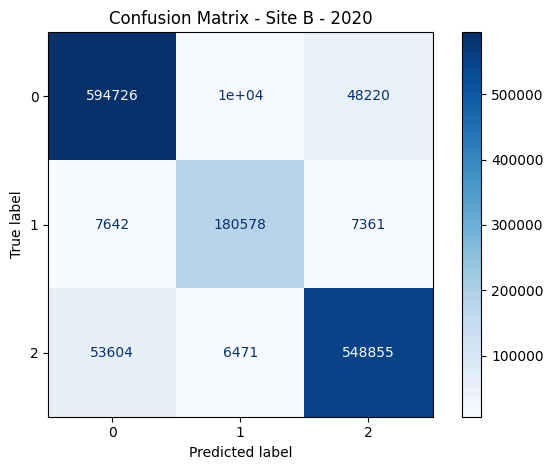


Training with 75000 samples...


Training Epoch 1: 100%|██████████| 1172/1172 [00:27<00:00, 42.75it/s]


Loss: 0.0794 + 1e-08 * 2748349.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.38it/s]


Epoch [1/10] Train Loss: 0.3370, Train Acc: 0.8799 | Val Loss: 0.2771, Val Acc: 0.9000


Training Epoch 2: 100%|██████████| 1172/1172 [00:26<00:00, 43.95it/s]


Loss: 0.2167 + 1e-08 * 2606632.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.18it/s]


Epoch [2/10] Train Loss: 0.2732, Train Acc: 0.9027 | Val Loss: 0.2671, Val Acc: 0.9041


Training Epoch 3: 100%|██████████| 1172/1172 [00:27<00:00, 43.19it/s]


Loss: 0.4187 + 1e-08 * 2494128.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.31it/s]


Epoch [3/10] Train Loss: 0.2577, Train Acc: 0.9087 | Val Loss: 0.2560, Val Acc: 0.9084


Training Epoch 4: 100%|██████████| 1172/1172 [00:26<00:00, 43.59it/s]


Loss: 0.2861 + 1e-08 * 2405199.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.26it/s]


Epoch [4/10] Train Loss: 0.2470, Train Acc: 0.9125 | Val Loss: 0.2501, Val Acc: 0.9100


Training Epoch 5: 100%|██████████| 1172/1172 [00:26<00:00, 43.85it/s]


Loss: 0.3399 + 1e-08 * 2341371.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.62it/s]


Epoch [5/10] Train Loss: 0.2374, Train Acc: 0.9150 | Val Loss: 0.2572, Val Acc: 0.9073


Training Epoch 6: 100%|██████████| 1172/1172 [00:27<00:00, 43.21it/s]


Loss: 0.2589 + 1e-08 * 2296658.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.68it/s]


Epoch [6/10] Train Loss: 0.2306, Train Acc: 0.9179 | Val Loss: 0.2524, Val Acc: 0.9084


Training Epoch 7: 100%|██████████| 1172/1172 [00:26<00:00, 44.18it/s]


Loss: 0.1346 + 1e-08 * 2266067.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.94it/s]


Epoch [7/10] Train Loss: 0.2232, Train Acc: 0.9206 | Val Loss: 0.2523, Val Acc: 0.9107


Training Epoch 8: 100%|██████████| 1172/1172 [00:27<00:00, 42.96it/s]


Loss: 0.1779 + 1e-08 * 2251138.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.56it/s]


Epoch [8/10] Train Loss: 0.2163, Train Acc: 0.9225 | Val Loss: 0.2526, Val Acc: 0.9091


Training Epoch 9: 100%|██████████| 1172/1172 [00:26<00:00, 44.11it/s]


Loss: 0.0894 + 1e-08 * 2238364.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.43it/s]


Epoch [9/10] Train Loss: 0.2109, Train Acc: 0.9250 | Val Loss: 0.2523, Val Acc: 0.9091


Training Epoch 10: 100%|██████████| 1172/1172 [00:26<00:00, 43.69it/s]


Loss: 0.1166 + 1e-08 * 2231028.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.26it/s]


Epoch [10/10] Train Loss: 0.2047, Train Acc: 0.9268 | Val Loss: 0.2498, Val Acc: 0.9104


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:40<00:00, 142.03it/s]


Stochastic Accuracy (mean over T): 0.9100
Cohen's Kappa: 0.8519
Per-class F1: [0.910597   0.91508836 0.9075844 ]
Average F1 (macro): 0.9111


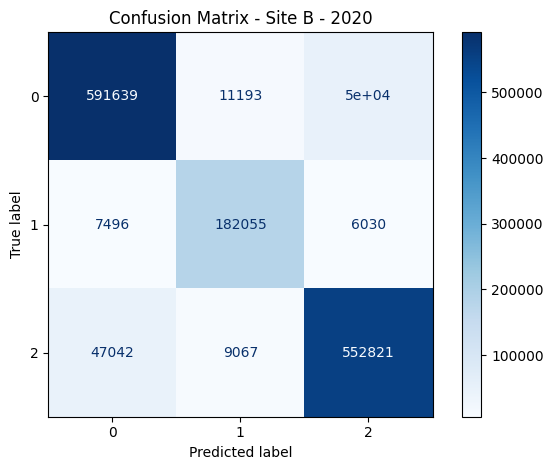


Training with 100000 samples...


Training Epoch 1: 100%|██████████| 1563/1563 [00:35<00:00, 43.83it/s]


Loss: 0.3411 + 1e-08 * 2694239.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.80it/s]


Epoch [1/10] Train Loss: 0.3206, Train Acc: 0.8857 | Val Loss: 0.2757, Val Acc: 0.9008


Training Epoch 2: 100%|██████████| 1563/1563 [00:35<00:00, 43.62it/s]


Loss: 0.1403 + 1e-08 * 2510684.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.36it/s]


Epoch [2/10] Train Loss: 0.2661, Train Acc: 0.9050 | Val Loss: 0.2786, Val Acc: 0.8989


Training Epoch 3: 100%|██████████| 1563/1563 [00:35<00:00, 43.58it/s]


Loss: 0.2657 + 1e-08 * 2372957.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.10it/s]


Epoch [3/10] Train Loss: 0.2516, Train Acc: 0.9105 | Val Loss: 0.2596, Val Acc: 0.9053


Training Epoch 4: 100%|██████████| 1563/1563 [00:35<00:00, 43.68it/s]


Loss: 0.1829 + 1e-08 * 2273181.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.15it/s]


Epoch [4/10] Train Loss: 0.2410, Train Acc: 0.9143 | Val Loss: 0.2524, Val Acc: 0.9106


Training Epoch 5: 100%|██████████| 1563/1563 [00:35<00:00, 43.73it/s]


Loss: 0.3266 + 1e-08 * 2203944.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.67it/s]


Epoch [5/10] Train Loss: 0.2327, Train Acc: 0.9164 | Val Loss: 0.2487, Val Acc: 0.9103


Training Epoch 6: 100%|██████████| 1563/1563 [00:35<00:00, 43.86it/s]


Loss: 0.1814 + 1e-08 * 2154650.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.54it/s]


Epoch [6/10] Train Loss: 0.2259, Train Acc: 0.9186 | Val Loss: 0.2480, Val Acc: 0.9115


Training Epoch 7: 100%|██████████| 1563/1563 [00:35<00:00, 43.50it/s]


Loss: 0.3579 + 1e-08 * 2121595.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.79it/s]


Epoch [7/10] Train Loss: 0.2201, Train Acc: 0.9207 | Val Loss: 0.2447, Val Acc: 0.9125


Training Epoch 8: 100%|██████████| 1563/1563 [00:35<00:00, 43.43it/s]


Loss: 0.2303 + 1e-08 * 2103293.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.39it/s]


Epoch [8/10] Train Loss: 0.2144, Train Acc: 0.9225 | Val Loss: 0.2483, Val Acc: 0.9111


Training Epoch 9: 100%|██████████| 1563/1563 [00:35<00:00, 43.61it/s]


Loss: 0.1649 + 1e-08 * 2090432.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.98it/s]


Epoch [9/10] Train Loss: 0.2081, Train Acc: 0.9237 | Val Loss: 0.2442, Val Acc: 0.9120


Training Epoch 10: 100%|██████████| 1563/1563 [00:35<00:00, 43.71it/s]


Loss: 0.2393 + 1e-08 * 2089771.875


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.16it/s]


Epoch [10/10] Train Loss: 0.2038, Train Acc: 0.9267 | Val Loss: 0.2484, Val Acc: 0.9090


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:40<00:00, 141.60it/s]


Stochastic Accuracy (mean over T): 0.9097
Cohen's Kappa: 0.8514
Per-class F1: [0.91051795 0.91742074 0.90624695]
Average F1 (macro): 0.9114


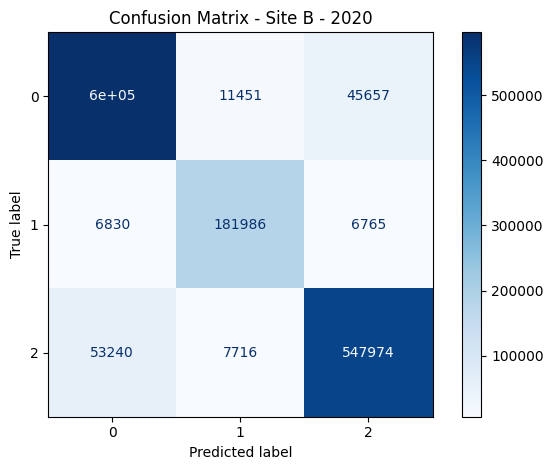


Training with 125000 samples...


Training Epoch 1: 100%|██████████| 1954/1954 [00:44<00:00, 43.56it/s]


Loss: 0.1371 + 1e-08 * 2641202.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.87it/s]


Epoch [1/10] Train Loss: 0.3111, Train Acc: 0.8890 | Val Loss: 0.2668, Val Acc: 0.9048


Training Epoch 2: 100%|██████████| 1954/1954 [00:44<00:00, 43.60it/s]


Loss: 0.1529 + 1e-08 * 2425864.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.38it/s]


Epoch [2/10] Train Loss: 0.2609, Train Acc: 0.9071 | Val Loss: 0.2674, Val Acc: 0.9029


Training Epoch 3: 100%|██████████| 1954/1954 [00:44<00:00, 43.61it/s]


Loss: 0.1372 + 1e-08 * 2280147.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.19it/s]


Epoch [3/10] Train Loss: 0.2483, Train Acc: 0.9111 | Val Loss: 0.2502, Val Acc: 0.9108


Training Epoch 4: 100%|██████████| 1954/1954 [00:44<00:00, 43.58it/s]


Loss: 0.5545 + 1e-08 * 2171114.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.19it/s]


Epoch [4/10] Train Loss: 0.2380, Train Acc: 0.9144 | Val Loss: 0.2459, Val Acc: 0.9118


Training Epoch 5: 100%|██████████| 1954/1954 [00:44<00:00, 43.61it/s]


Loss: 0.4128 + 1e-08 * 2096863.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.53it/s]


Epoch [5/10] Train Loss: 0.2303, Train Acc: 0.9170 | Val Loss: 0.2437, Val Acc: 0.9133


Training Epoch 6: 100%|██████████| 1954/1954 [00:44<00:00, 43.72it/s]


Loss: 0.1676 + 1e-08 * 2048168.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.70it/s]


Epoch [6/10] Train Loss: 0.2247, Train Acc: 0.9187 | Val Loss: 0.2461, Val Acc: 0.9118


Training Epoch 7: 100%|██████████| 1954/1954 [00:44<00:00, 43.73it/s]


Loss: 0.0514 + 1e-08 * 2016060.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.62it/s]


Epoch [7/10] Train Loss: 0.2192, Train Acc: 0.9200 | Val Loss: 0.2426, Val Acc: 0.9108


Training Epoch 8: 100%|██████████| 1954/1954 [00:44<00:00, 43.67it/s]


Loss: 0.2837 + 1e-08 * 1996285.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.86it/s]


Epoch [8/10] Train Loss: 0.2144, Train Acc: 0.9215 | Val Loss: 0.2413, Val Acc: 0.9132


Training Epoch 9: 100%|██████████| 1954/1954 [00:44<00:00, 43.72it/s]


Loss: 0.1175 + 1e-08 * 1983861.875


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.18it/s]


Epoch [9/10] Train Loss: 0.2092, Train Acc: 0.9237 | Val Loss: 0.2404, Val Acc: 0.9131


Training Epoch 10: 100%|██████████| 1954/1954 [00:44<00:00, 43.60it/s]


Loss: 0.0657 + 1e-08 * 1986785.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.01it/s]


Epoch [10/10] Train Loss: 0.2045, Train Acc: 0.9256 | Val Loss: 0.2435, Val Acc: 0.9113


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:41<00:00, 141.37it/s]


Stochastic Accuracy (mean over T): 0.9106
Cohen's Kappa: 0.8529
Per-class F1: [0.90989426 0.92177194 0.90779631]
Average F1 (macro): 0.9132


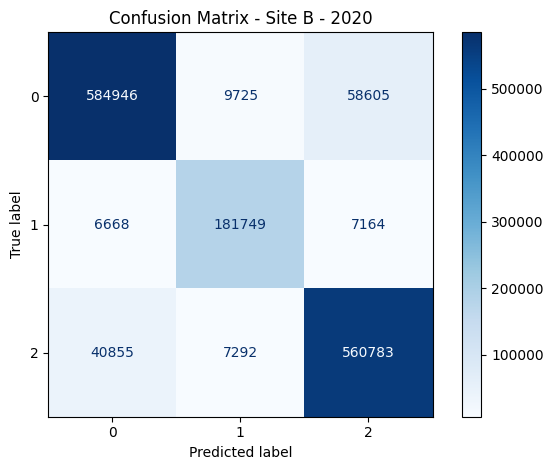


Training with 150000 samples...


Training Epoch 1: 100%|██████████| 2344/2344 [00:53<00:00, 43.48it/s]


Loss: 0.2436 + 1e-08 * 2595797.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.23it/s]


Epoch [1/10] Train Loss: 0.3061, Train Acc: 0.8909 | Val Loss: 0.2691, Val Acc: 0.9039


Training Epoch 2: 100%|██████████| 2344/2344 [00:54<00:00, 43.16it/s]


Loss: 0.1080 + 1e-08 * 2359395.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.20it/s]


Epoch [2/10] Train Loss: 0.2586, Train Acc: 0.9088 | Val Loss: 0.2616, Val Acc: 0.9044


Training Epoch 3: 100%|██████████| 2344/2344 [00:54<00:00, 43.02it/s]


Loss: 0.1886 + 1e-08 * 2198023.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.29it/s]


Epoch [3/10] Train Loss: 0.2443, Train Acc: 0.9124 | Val Loss: 0.2447, Val Acc: 0.9112


Training Epoch 4: 100%|██████████| 2344/2344 [00:54<00:00, 43.27it/s]


Loss: 0.1157 + 1e-08 * 2091935.125


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.25it/s]


Epoch [4/10] Train Loss: 0.2348, Train Acc: 0.9158 | Val Loss: 0.2476, Val Acc: 0.9104


Training Epoch 5: 100%|██████████| 2344/2344 [00:53<00:00, 43.58it/s]


Loss: 0.1789 + 1e-08 * 2023002.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.63it/s]


Epoch [5/10] Train Loss: 0.2282, Train Acc: 0.9172 | Val Loss: 0.2422, Val Acc: 0.9118


Training Epoch 6: 100%|██████████| 2344/2344 [00:54<00:00, 43.31it/s]


Loss: 0.1445 + 1e-08 * 1970527.875


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.63it/s]


Epoch [6/10] Train Loss: 0.2225, Train Acc: 0.9194 | Val Loss: 0.2438, Val Acc: 0.9103


Training Epoch 7: 100%|██████████| 2344/2344 [00:53<00:00, 43.44it/s]


Loss: 0.2844 + 1e-08 * 1944518.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.99it/s]


Epoch [7/10] Train Loss: 0.2165, Train Acc: 0.9223 | Val Loss: 0.2411, Val Acc: 0.9141


Training Epoch 8: 100%|██████████| 2344/2344 [00:54<00:00, 43.36it/s]


Loss: 0.1063 + 1e-08 * 1927408.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.50it/s]


Epoch [8/10] Train Loss: 0.2115, Train Acc: 0.9232 | Val Loss: 0.2372, Val Acc: 0.9140


Training Epoch 9: 100%|██████████| 2344/2344 [00:53<00:00, 43.69it/s]


Loss: 0.5265 + 1e-08 * 1919697.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.39it/s]


Epoch [9/10] Train Loss: 0.2070, Train Acc: 0.9253 | Val Loss: 0.2367, Val Acc: 0.9157


Training Epoch 10: 100%|██████████| 2344/2344 [00:53<00:00, 43.52it/s]


Loss: 0.1937 + 1e-08 * 1920834.875


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.71it/s]


Epoch [10/10] Train Loss: 0.2036, Train Acc: 0.9263 | Val Loss: 0.2344, Val Acc: 0.9143


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:40<00:00, 141.91it/s]


Stochastic Accuracy (mean over T): 0.9145
Cohen's Kappa: 0.8592
Per-class F1: [0.91479291 0.92257021 0.91164654]
Average F1 (macro): 0.9163


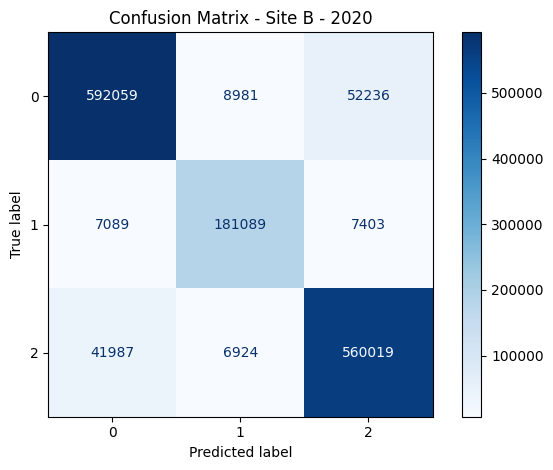


Training with 175000 samples...


Training Epoch 1: 100%|██████████| 2735/2735 [01:02<00:00, 43.54it/s]


Loss: 0.1022 + 1e-08 * 2543443.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.69it/s]


Epoch [1/10] Train Loss: 0.3013, Train Acc: 0.8926 | Val Loss: 0.2689, Val Acc: 0.9033


Training Epoch 2: 100%|██████████| 2735/2735 [01:02<00:00, 43.47it/s]


Loss: 0.1617 + 1e-08 * 2278087.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.17it/s]


Epoch [2/10] Train Loss: 0.2554, Train Acc: 0.9089 | Val Loss: 0.2531, Val Acc: 0.9078


Training Epoch 3: 100%|██████████| 2735/2735 [01:02<00:00, 43.59it/s]


Loss: 0.2401 + 1e-08 * 2115218.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.03it/s]


Epoch [3/10] Train Loss: 0.2417, Train Acc: 0.9129 | Val Loss: 0.2442, Val Acc: 0.9113


Training Epoch 4: 100%|██████████| 2735/2735 [01:02<00:00, 43.62it/s]


Loss: 0.3114 + 1e-08 * 2012228.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.09it/s]


Epoch [4/10] Train Loss: 0.2334, Train Acc: 0.9156 | Val Loss: 0.2404, Val Acc: 0.9124


Training Epoch 5: 100%|██████████| 2735/2735 [01:02<00:00, 43.58it/s]


Loss: 0.1023 + 1e-08 * 1943494.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.53it/s]


Epoch [5/10] Train Loss: 0.2265, Train Acc: 0.9179 | Val Loss: 0.2384, Val Acc: 0.9137


Training Epoch 6: 100%|██████████| 2735/2735 [01:02<00:00, 43.54it/s]


Loss: 0.1974 + 1e-08 * 1897352.25


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 136.82it/s]


Epoch [6/10] Train Loss: 0.2204, Train Acc: 0.9203 | Val Loss: 0.2451, Val Acc: 0.9110


Training Epoch 7: 100%|██████████| 2735/2735 [01:02<00:00, 43.68it/s]


Loss: 0.1549 + 1e-08 * 1871569.125


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.76it/s]


Epoch [7/10] Train Loss: 0.2167, Train Acc: 0.9212 | Val Loss: 0.2344, Val Acc: 0.9149


Training Epoch 8: 100%|██████████| 2735/2735 [01:02<00:00, 43.67it/s]


Loss: 0.1223 + 1e-08 * 1856305.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.38it/s]


Epoch [8/10] Train Loss: 0.2107, Train Acc: 0.9238 | Val Loss: 0.2368, Val Acc: 0.9150


Training Epoch 9: 100%|██████████| 2735/2735 [01:02<00:00, 43.53it/s]


Loss: 0.5065 + 1e-08 * 1852364.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.37it/s]


Epoch [9/10] Train Loss: 0.2066, Train Acc: 0.9245 | Val Loss: 0.2318, Val Acc: 0.9155


Training Epoch 10: 100%|██████████| 2735/2735 [01:03<00:00, 43.28it/s]


Loss: 0.0890 + 1e-08 * 1859628.875


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.74it/s]


Epoch [10/10] Train Loss: 0.2034, Train Acc: 0.9261 | Val Loss: 0.2312, Val Acc: 0.9163


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:41<00:00, 141.13it/s]


Stochastic Accuracy (mean over T): 0.9160
Cohen's Kappa: 0.8616
Per-class F1: [0.91637916 0.92345705 0.91320427]
Average F1 (macro): 0.9177


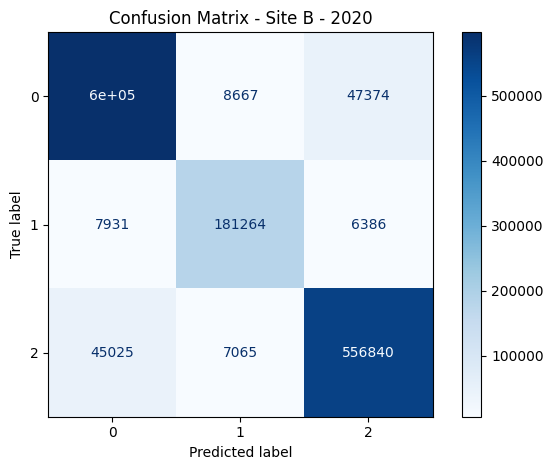


Training with 200000 samples...


Training Epoch 1: 100%|██████████| 3125/3125 [01:11<00:00, 43.74it/s]


Loss: 0.2394 + 1e-08 * 2507589.75


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 137.71it/s]


Epoch [1/10] Train Loss: 0.2961, Train Acc: 0.8948 | Val Loss: 0.2672, Val Acc: 0.9046


Training Epoch 2: 100%|██████████| 3125/3125 [01:11<00:00, 43.76it/s]


Loss: 0.2542 + 1e-08 * 2235987.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.07it/s]


Epoch [2/10] Train Loss: 0.2529, Train Acc: 0.9095 | Val Loss: 0.2500, Val Acc: 0.9093


Training Epoch 3: 100%|██████████| 3125/3125 [01:11<00:00, 43.52it/s]


Loss: 0.2227 + 1e-08 * 2067820.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.65it/s]


Epoch [3/10] Train Loss: 0.2397, Train Acc: 0.9140 | Val Loss: 0.2435, Val Acc: 0.9125


Training Epoch 4: 100%|██████████| 3125/3125 [01:11<00:00, 43.49it/s]


Loss: 0.1641 + 1e-08 * 1962183.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.53it/s]


Epoch [4/10] Train Loss: 0.2314, Train Acc: 0.9164 | Val Loss: 0.2368, Val Acc: 0.9149


Training Epoch 5: 100%|██████████| 3125/3125 [01:11<00:00, 43.56it/s]


Loss: 0.2353 + 1e-08 * 1894228.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.87it/s]


Epoch [5/10] Train Loss: 0.2248, Train Acc: 0.9188 | Val Loss: 0.2326, Val Acc: 0.9146


Training Epoch 6: 100%|██████████| 3125/3125 [01:11<00:00, 43.59it/s]


Loss: 0.1132 + 1e-08 * 1849033.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.26it/s]


Epoch [6/10] Train Loss: 0.2192, Train Acc: 0.9203 | Val Loss: 0.2379, Val Acc: 0.9144


Training Epoch 7: 100%|██████████| 3125/3125 [01:11<00:00, 43.53it/s]


Loss: 0.1360 + 1e-08 * 1824459.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.06it/s]


Epoch [7/10] Train Loss: 0.2141, Train Acc: 0.9225 | Val Loss: 0.2446, Val Acc: 0.9111


Training Epoch 8: 100%|██████████| 3125/3125 [01:11<00:00, 43.50it/s]


Loss: 0.2513 + 1e-08 * 1809413.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.22it/s]


Epoch [8/10] Train Loss: 0.2096, Train Acc: 0.9240 | Val Loss: 0.2323, Val Acc: 0.9153


Training Epoch 10: 100%|██████████| 3125/3125 [01:12<00:00, 43.38it/s]


Loss: 0.1803 + 1e-08 * 1811544.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.44it/s]


Epoch [10/10] Train Loss: 0.2021, Train Acc: 0.9260 | Val Loss: 0.2333, Val Acc: 0.9157


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:41<00:00, 141.46it/s]


Stochastic Accuracy (mean over T): 0.9160
Cohen's Kappa: 0.8613
Per-class F1: [0.91596737 0.92754519 0.91248486]
Average F1 (macro): 0.9187


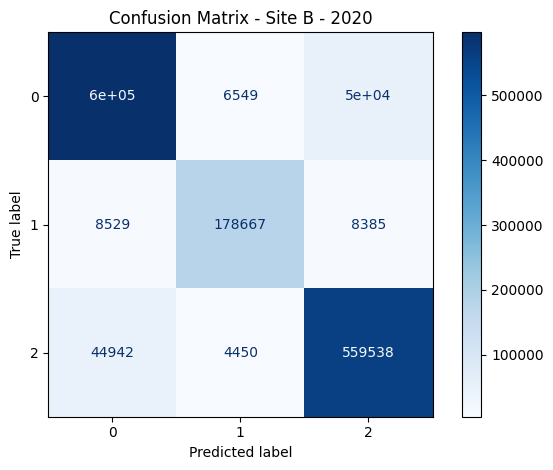


Training with 225000 samples...


Training Epoch 1: 100%|██████████| 3516/3516 [01:20<00:00, 43.75it/s]


Loss: 0.3079 + 1e-08 * 2454190.0


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 136.32it/s]


Epoch [1/10] Train Loss: 0.2926, Train Acc: 0.8960 | Val Loss: 0.2617, Val Acc: 0.9082


Training Epoch 2: 100%|██████████| 3516/3516 [01:20<00:00, 43.78it/s]


Loss: 0.1545 + 1e-08 * 2170541.25


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 137.90it/s]


Epoch [2/10] Train Loss: 0.2507, Train Acc: 0.9104 | Val Loss: 0.2442, Val Acc: 0.9113


Training Epoch 3: 100%|██████████| 3516/3516 [01:20<00:00, 43.61it/s]


Loss: 0.1948 + 1e-08 * 1997899.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.23it/s]


Epoch [3/10] Train Loss: 0.2383, Train Acc: 0.9139 | Val Loss: 0.2442, Val Acc: 0.9114


Training Epoch 4: 100%|██████████| 3516/3516 [01:20<00:00, 43.44it/s]


Loss: 0.4864 + 1e-08 * 1892982.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.28it/s]


Epoch [4/10] Train Loss: 0.2294, Train Acc: 0.9170 | Val Loss: 0.2383, Val Acc: 0.9141


Training Epoch 5: 100%|██████████| 3516/3516 [01:20<00:00, 43.45it/s]


Loss: 0.1740 + 1e-08 * 1834812.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.75it/s]


Epoch [5/10] Train Loss: 0.2229, Train Acc: 0.9191 | Val Loss: 0.2378, Val Acc: 0.9121


Training Epoch 6: 100%|██████████| 3516/3516 [01:20<00:00, 43.45it/s]


Loss: 0.1235 + 1e-08 * 1796511.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.57it/s]


Epoch [6/10] Train Loss: 0.2176, Train Acc: 0.9213 | Val Loss: 0.2401, Val Acc: 0.9136


Training Epoch 7: 100%|██████████| 3516/3516 [01:20<00:00, 43.48it/s]


Loss: 0.1373 + 1e-08 * 1769015.875


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.64it/s]


Epoch [7/10] Train Loss: 0.2131, Train Acc: 0.9231 | Val Loss: 0.2321, Val Acc: 0.9139


Training Epoch 8: 100%|██████████| 3516/3516 [01:20<00:00, 43.54it/s]


Loss: 0.2306 + 1e-08 * 1755449.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.71it/s]


Epoch [8/10] Train Loss: 0.2089, Train Acc: 0.9233 | Val Loss: 0.2312, Val Acc: 0.9147


Training Epoch 9: 100%|██████████| 3516/3516 [01:21<00:00, 43.41it/s]


Loss: 0.2295 + 1e-08 * 1751728.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.52it/s]


Epoch [9/10] Train Loss: 0.2051, Train Acc: 0.9255 | Val Loss: 0.2325, Val Acc: 0.9143


Training Epoch 10: 100%|██████████| 3516/3516 [01:20<00:00, 43.48it/s]


Loss: 0.1085 + 1e-08 * 1756861.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.44it/s]


Epoch [10/10] Train Loss: 0.2021, Train Acc: 0.9263 | Val Loss: 0.2310, Val Acc: 0.9137


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:41<00:00, 141.09it/s]


Stochastic Accuracy (mean over T): 0.9135
Cohen's Kappa: 0.8581
Per-class F1: [0.91345859 0.9179014  0.91217481]
Average F1 (macro): 0.9145


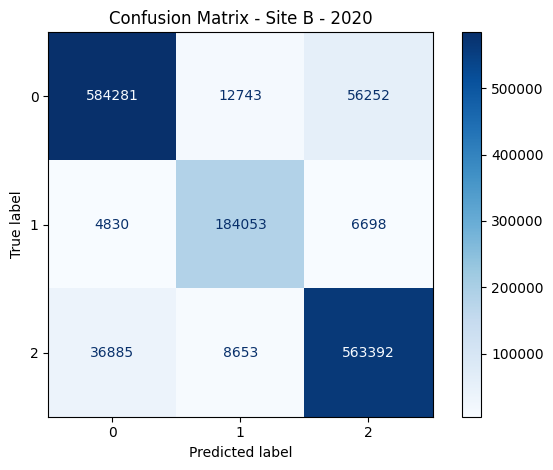


Training with 250000 samples...


Training Epoch 1: 100%|██████████| 3907/3907 [01:29<00:00, 43.82it/s]


Loss: 0.1423 + 1e-08 * 2417090.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.36it/s]


Epoch [1/10] Train Loss: 0.2900, Train Acc: 0.8969 | Val Loss: 0.2576, Val Acc: 0.9085


Training Epoch 2: 100%|██████████| 3907/3907 [01:29<00:00, 43.69it/s]


Loss: 0.1812 + 1e-08 * 2122450.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.89it/s]


Epoch [2/10] Train Loss: 0.2480, Train Acc: 0.9107 | Val Loss: 0.2443, Val Acc: 0.9115


Training Epoch 3: 100%|██████████| 3907/3907 [01:29<00:00, 43.68it/s]


Loss: 0.2852 + 1e-08 * 1953144.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.67it/s]


Epoch [3/10] Train Loss: 0.2360, Train Acc: 0.9145 | Val Loss: 0.2469, Val Acc: 0.9102


Training Epoch 4: 100%|██████████| 3907/3907 [01:29<00:00, 43.69it/s]


Loss: 0.2356 + 1e-08 * 1848888.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.63it/s]


Epoch [4/10] Train Loss: 0.2281, Train Acc: 0.9170 | Val Loss: 0.2339, Val Acc: 0.9154


Training Epoch 5: 100%|██████████| 3907/3907 [01:29<00:00, 43.55it/s]


Loss: 0.1662 + 1e-08 * 1791034.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.03it/s]


Epoch [5/10] Train Loss: 0.2208, Train Acc: 0.9199 | Val Loss: 0.2341, Val Acc: 0.9151


Training Epoch 6: 100%|██████████| 3907/3907 [01:30<00:00, 43.34it/s]


Loss: 0.0799 + 1e-08 * 1748546.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.29it/s]


Epoch [6/10] Train Loss: 0.2156, Train Acc: 0.9214 | Val Loss: 0.2338, Val Acc: 0.9143


Training Epoch 7: 100%|██████████| 3907/3907 [01:29<00:00, 43.53it/s]


Loss: 0.0916 + 1e-08 * 1722995.25


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 136.88it/s]


Epoch [7/10] Train Loss: 0.2117, Train Acc: 0.9227 | Val Loss: 0.2293, Val Acc: 0.9142


Training Epoch 8: 100%|██████████| 3907/3907 [01:29<00:00, 43.63it/s]


Loss: 0.2566 + 1e-08 * 1711203.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.85it/s]


Epoch [8/10] Train Loss: 0.2076, Train Acc: 0.9242 | Val Loss: 0.2271, Val Acc: 0.9177


Training Epoch 9: 100%|██████████| 3907/3907 [01:29<00:00, 43.41it/s]


Loss: 0.1722 + 1e-08 * 1712538.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.85it/s]


Epoch [9/10] Train Loss: 0.2040, Train Acc: 0.9253 | Val Loss: 0.2302, Val Acc: 0.9145


Training Epoch 10: 100%|██████████| 3907/3907 [01:30<00:00, 43.41it/s]


Loss: 0.2437 + 1e-08 * 1714415.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.77it/s]


Epoch [10/10] Train Loss: 0.2007, Train Acc: 0.9267 | Val Loss: 0.2294, Val Acc: 0.9140


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:42<00:00, 140.02it/s]


Stochastic Accuracy (mean over T): 0.9137
Cohen's Kappa: 0.8583
Per-class F1: [0.91403137 0.91889192 0.9117239 ]
Average F1 (macro): 0.9149


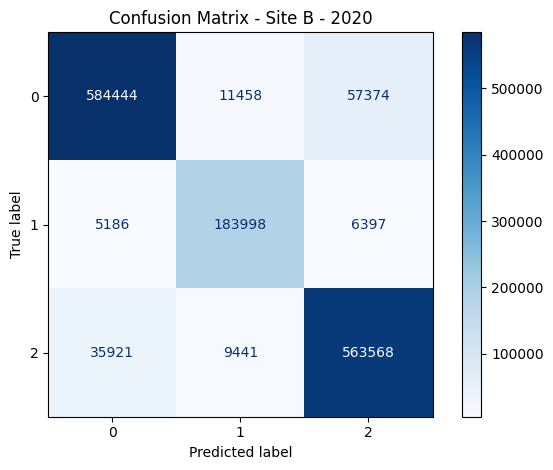

In [29]:
# Subsampled Training
if flag_subsampled:
    elbow_history = subsampled_training(X_train, y_train, val_dataloader, start=25000, end=250000, step=25000)
    
else: 
    # Simple training
    train_losses, val_losses, train_accs, val_accs = train(model, train_dataset, train_dataloader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)

    acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
    # Printing and plotting
    print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Per-class F1: {per_class_f1}")
    print(f"Average F1 (macro): {avg_f1:.4f}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
    plt.tight_layout()
    plt.show()

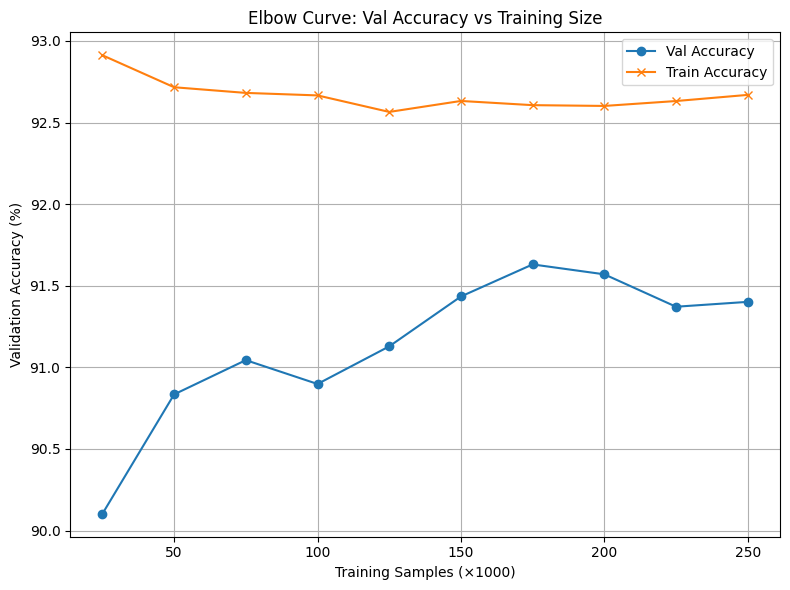

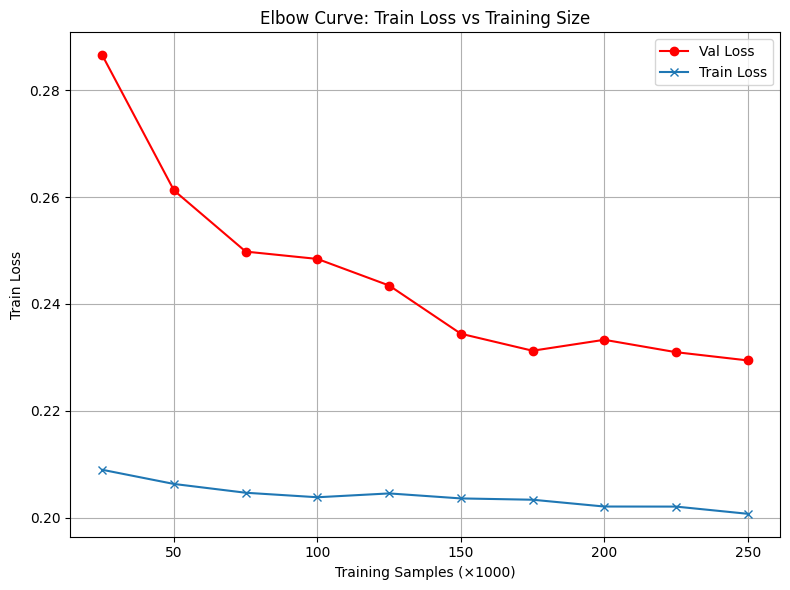

In [30]:
if flag_subsampled:
    def plot_elbow_curve(elbow_history):
        x_vals = [x / 1000 for x in elbow_history["subset_size"]]
    
        # Accuracy
        plt.figure(figsize=(8, 6))
        y_vals = [acc * 100 for acc in elbow_history["val_accuracy"]]
        plt.plot(x_vals, y_vals, marker='o', label='Val Accuracy')
        plt.plot(x_vals, [acc * 100 for acc in elbow_history['train_accuracy']], marker='x', label='Train Accuracy')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Validation Accuracy (%)")
        plt.title("Elbow Curve: Val Accuracy vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
        # Train Loss
        plt.figure(figsize=(8, 6))
        y_vals = elbow_history["val_loss"]  # raw loss
        plt.plot(x_vals, y_vals, marker='o', color='red', label='Val Loss')
        plt.plot(x_vals, elbow_history["train_loss"], marker='x', label='Train Loss')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Train Loss")
        plt.title("Elbow Curve: Train Loss vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    plot_elbow_curve(elbow_history)

else: 
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## Saving Results

In [31]:
if flag_subsampled:
    def save_elbow_results_to_excel(filename, elbow_history):
        # Load or create workbook
        if os.path.exists(filename):
            wb = load_workbook(filename)
            ws = wb.active
        else:
            wb = Workbook()
            ws = wb.active
    
            # Header row with bold font
            headers = ["Experiments", "Results"]
            bold_font = Font(bold=True)
            ws.append(headers)
    
            for col_num in range(1, len(headers) + 1):
                ws.cell(row=1, column=col_num).font = bold_font
    
        # For each subset size, append a row
        for i in range(len(elbow_history["subset_size"])):
            subset = elbow_history["subset_size"][i]
            train_acc = elbow_history["train_accuracy"][i] * 100
            train_loss = elbow_history["train_loss"][i]
            val_acc = elbow_history["val_accuracy"][i] * 100
            val_loss = elbow_history["val_loss"][i]
            val_avg_f1 = elbow_history["val_avg_f1"][i] * 100
            kappa = elbow_history["kappa"][i]
    
    
            experiment_name = f"Labeled Samples: {subset}"
            results_str = (
                f"TrainAcc = {train_acc:.2f}%, "
                f"TrainLoss = {train_loss:.4f}, "
                f"ValAcc = {val_acc:.2f}%, "
                f"ValLoss = {val_loss:.4f}"
                f"AvgF1 = {val_avg_f1:.2f}%"
                f"Kappa = {kappa:.4f}"
            )
    
            ws.append([experiment_name, results_str])
    
        wb.save(filename)
        print(f"Results saved to {filename}")
    
save_elbow_results_to_excel(
    filename="Results.xlsx",
    elbow_history=elbow_history
)

Results saved to Results.xlsx


<hr>